
=== LOO XGBoost - Dataset - Feature Set 1 ===
Accuracy: 0.9091
Confusion matrix [[TN FP],[FN TP]]:
[[56  3]
 [ 5 24]]


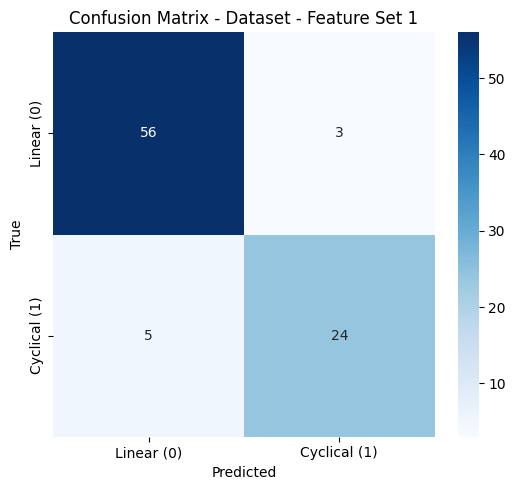


Incorrect predictions:
            ID  True  Pred  Conf_Pred
A0A097ZLP5_5_1     0     1   0.992990
    Q1XBU5_4_2     0     1   0.977302
    O22340_2_1     1     0   0.967595
    Q2XSC6_1_1     1     0   0.959627
    Q20HU7_5_2     1     0   0.692453
A0A0F6PMD0_3_1     1     0   0.680936
    Q9M7C9_2_1     1     0   0.547874
      D5SL78_1     0     1   0.529715
Saved: LOOout\loo_Dataset_FS1_misclassified.csv
Saved LOO mean importance CSV: LOOout\loo_mean_importance_Dataset_Feature_Set_1.csv
Saved LOO mean importance: LOOout\loo_mean_importance_Dataset_Feature_Set_1.png


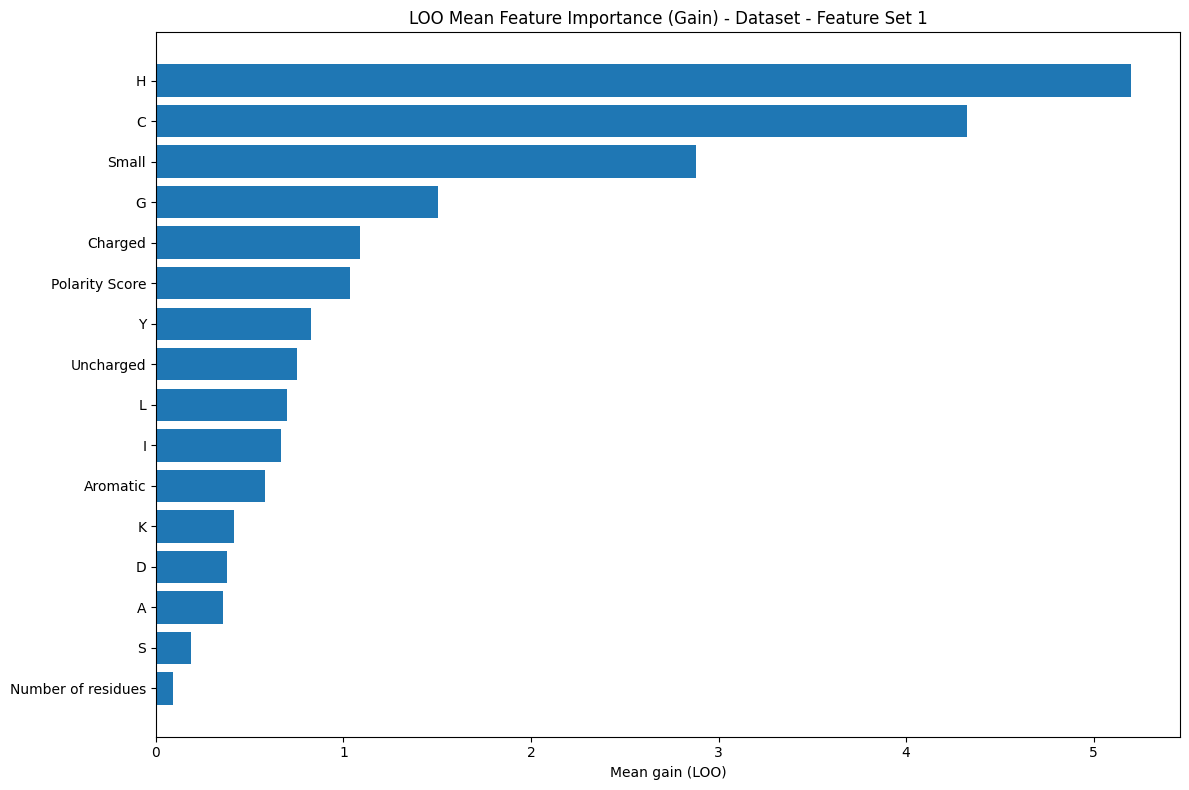

Saved correlation matrix: LOOout\corrmatrix_Dataset_Feature_Set_1.png


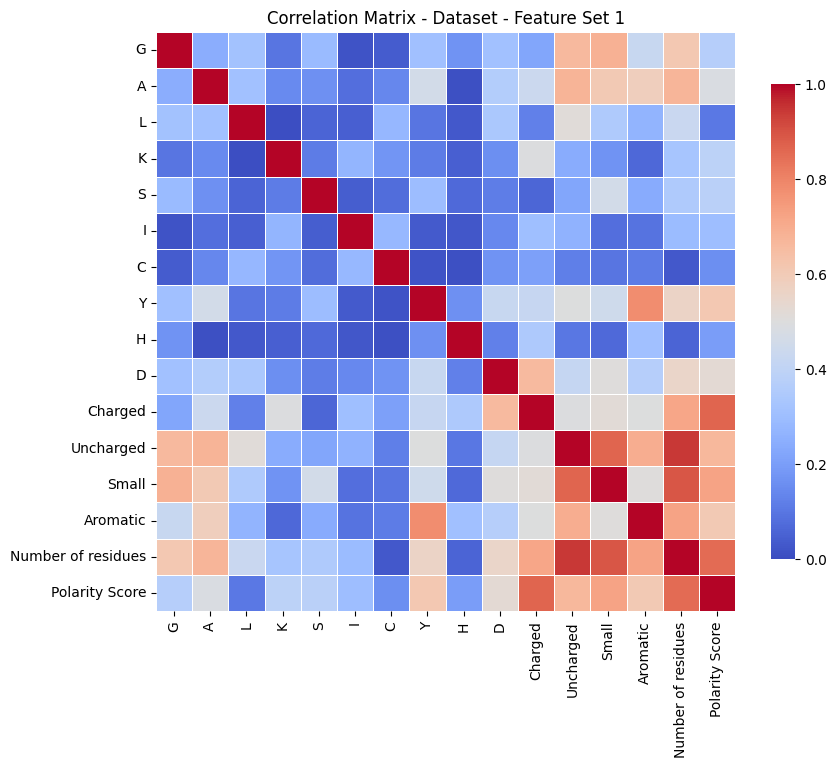


=== LOO XGBoost - Dataset - Feature Set 2 ===
Accuracy: 0.9205
Confusion matrix [[TN FP],[FN TP]]:
[[56  3]
 [ 4 25]]


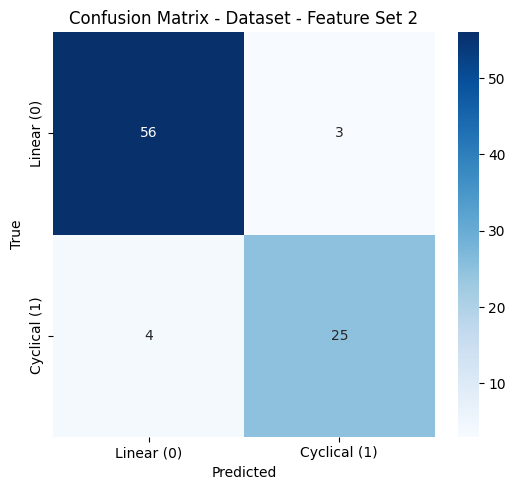


Incorrect predictions:
             ID  True  Pred  Conf_Pred
 A0A097ZLP5_5_1     0     1   0.998026
     Q1XBU5_4_2     0     1   0.990657
     Q2XSC6_1_1     1     0   0.952461
     O22340_2_1     1     0   0.924051
     Q6F5H2_3_1     1     0   0.857241
     Q20HU7_5_2     1     0   0.726704
hmoChr44410_4_1     0     1   0.536944
Saved: LOOout\loo_Dataset_FS2_misclassified.csv
Saved LOO mean importance CSV: LOOout\loo_mean_importance_Dataset_Feature_Set_2.csv
Saved LOO mean importance: LOOout\loo_mean_importance_Dataset_Feature_Set_2.png


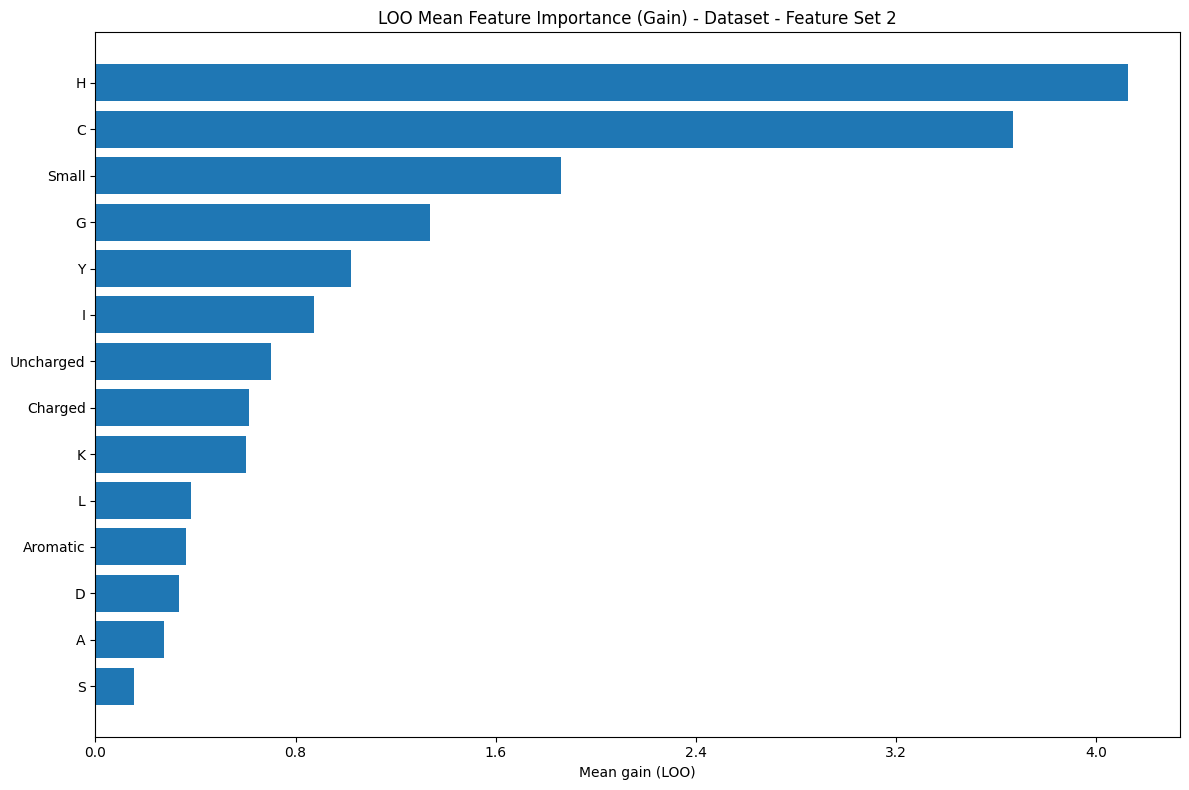

Saved correlation matrix: LOOout\corrmatrix_Dataset_Feature_Set_2.png


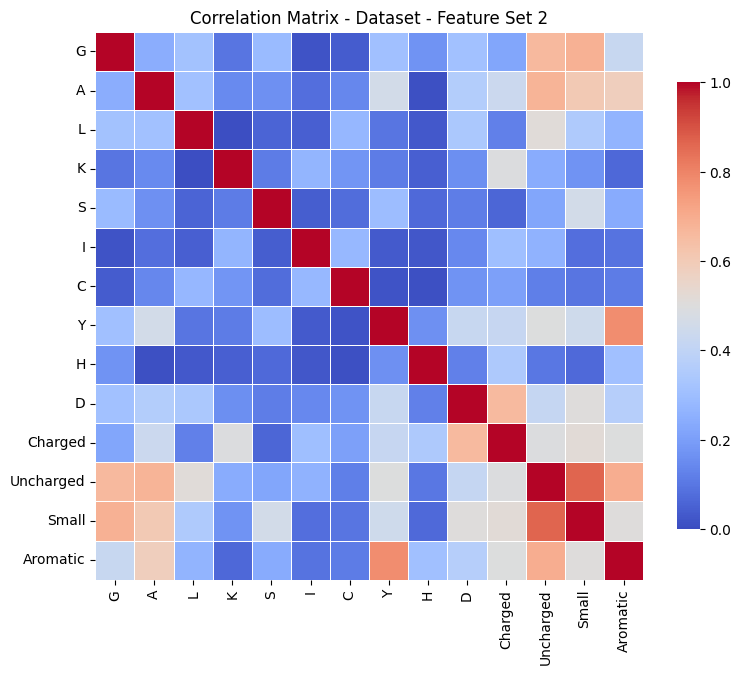


=== LOO XGBoost - Dataset - All Features ===
Accuracy: 0.8636
Confusion matrix [[TN FP],[FN TP]]:
[[53  6]
 [ 6 23]]


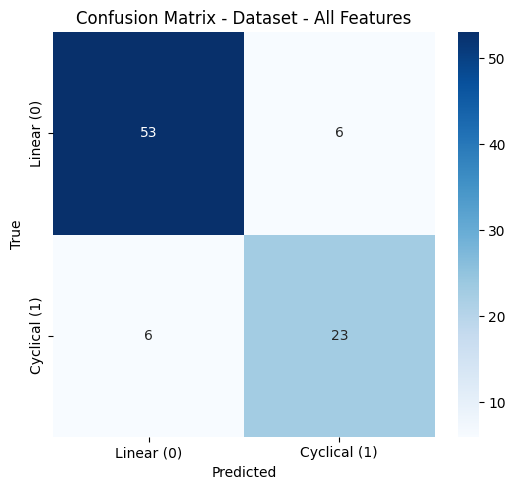


Incorrect predictions:
                          ID  True  Pred  Conf_Pred
                  Q20HU7_5_2     1     0   0.986837
                  O22340_2_1     1     0   0.980867
         slectg065_np871_3_1     0     1   0.968199
vodctg000225_np551212959_3_1     0     1   0.967547
                  Q675L2_3_1     0     1   0.965669
                  Q1XBU5_4_2     0     1   0.958758
             hmoChr44410_4_1     0     1   0.868410
                  Q2XSC6_1_1     1     0   0.831404
                  B0F4G4_1_1     1     0   0.785514
                  B6F137_3_1     0     1   0.696330
                  Q9M7C9_2_1     1     0   0.632884
                  Q675L1_4_2     1     0   0.508915
Saved: LOOout\loo_Dataset_FULL_misclassified.csv
Saved LOO mean importance CSV: LOOout\loo_mean_importance_Dataset_All_Features.csv
Saved LOO mean importance: LOOout\loo_mean_importance_Dataset_All_Features.png


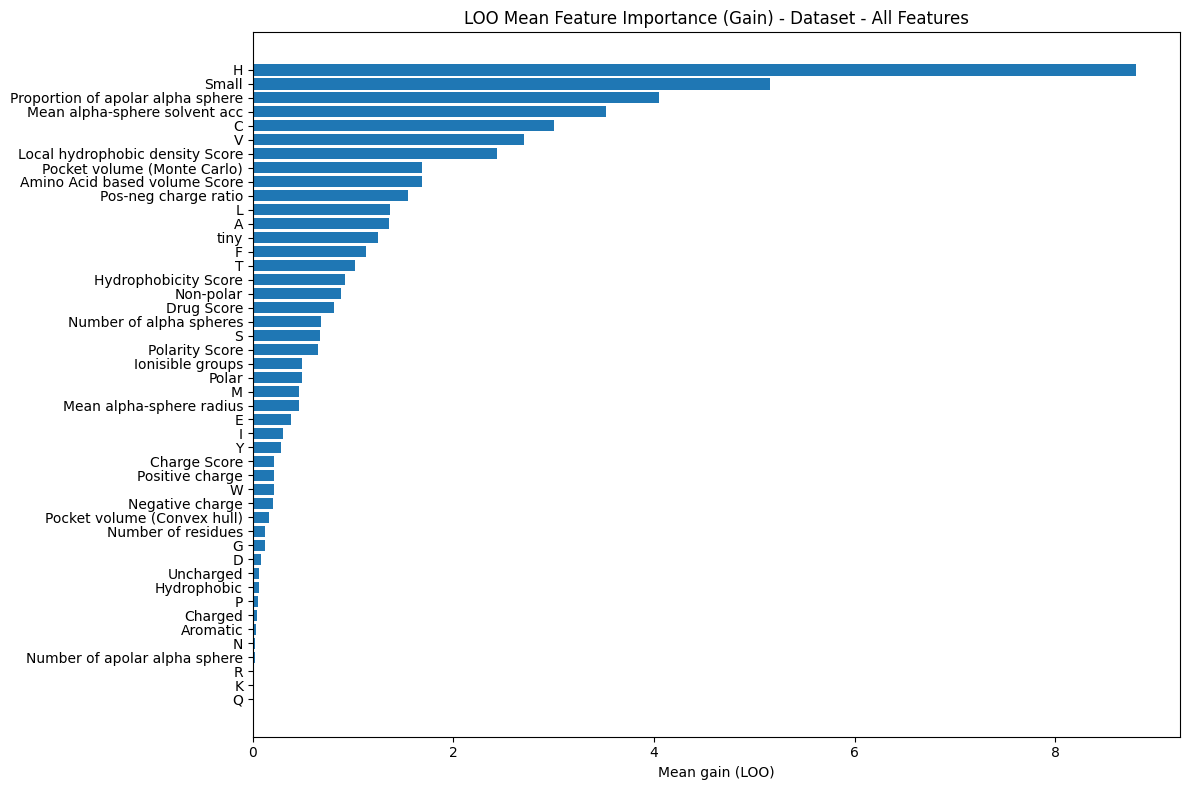

Saved correlation matrix: LOOout\corrmatrix_Dataset_All_Features.png


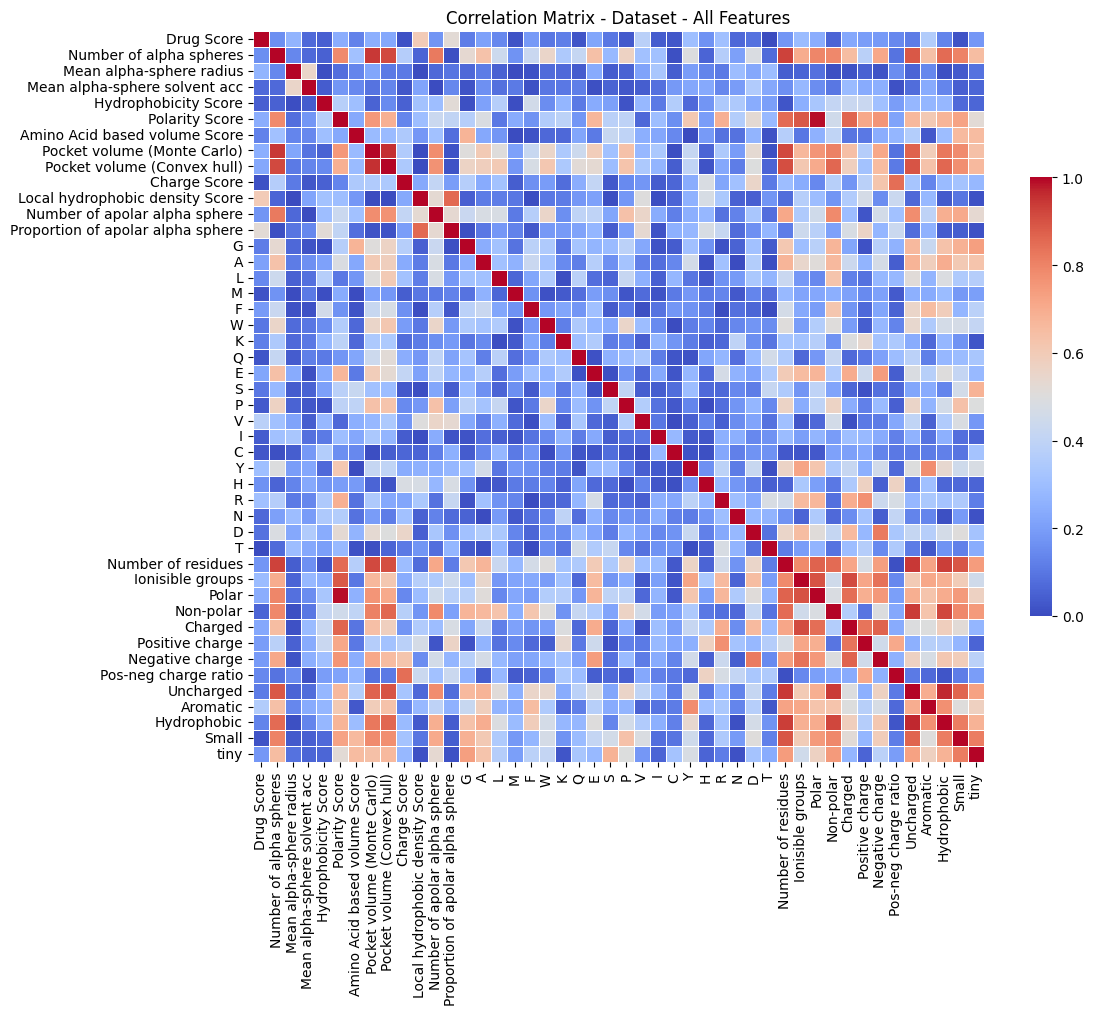


=== LOO Summary ===
Dataset   Feature Set  Accuracy  TN  FP  FN  TP
Dataset Feature Set 1  0.909091  56   3   5  24
Dataset Feature Set 2  0.920455  56   3   4  25
Dataset  All Features  0.863636  53   6   6  23
Saved: LOOout\loo_summary.csv


In [4]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import LeaveOneOut
from xgboost import XGBClassifier
from matplotlib.ticker import MaxNLocator

# model parameters and configuration
TARGET = 'Cyclical'
FS2 = [
    'Glycine - G', 'Alanine - A', 'Leucine - L', 'Lysine - K', 'Serine - S',
    'Isoleucine - I', 'Cysteine - C', 'Tyrosine - Y', 'Histidine - H', 'Aspartic Acid - D',
    'Charged', 'Uncharged', 'Small', 'Aromatic'
]
FS1_EXTRAS = ['Number of residues', 'Polarity Score']
DATA_PATH = 'FullDataset.csv'
FIGSIZE_BAR = (12, 8)
DPI_SAVE = 600
CLEAN_BBOX = dict(bbox_inches='tight', pad_inches=0.1 / 2.54)
OUT_DIR = 'LOOout'
os.makedirs(OUT_DIR, exist_ok=True)

# model setup and utility functions
def make_model():
    params = dict(
        eval_metric='logloss',
        reg_alpha=0.1,
        reg_lambda=1.0,
        verbosity=0,
        random_state=42,
        tree_method='hist',
    )
    try:
        return XGBClassifier(device='cuda', **params)
    except Exception:
        return XGBClassifier(**params)

# dataset loading and preparation
def detect_id_column(df: pd.DataFrame) -> str | None:
    return 'Protein' if 'Protein' in df.columns else None


def load_dataset(path: str):
    df = pd.read_csv(path)
    df = df.drop(columns=['Unnamed: 0'], errors='ignore')
    id_col = detect_id_column(df)

    missing = [c for c in FS2 if c not in df.columns]
    if missing:
        raise KeyError(f"{path}: missing FS2 columns: {missing}")

    fs1_cols = FS2 + [c for c in FS1_EXTRAS if c in df.columns]
    X_fs2 = df[FS2].copy()
    X_fs1 = df[fs1_cols].copy()

    drop_cols = {TARGET}
    if id_col:
        drop_cols.add(id_col)
    num_cols = df.select_dtypes(include=[np.number]).columns
    X_full = df[[c for c in num_cols if c not in drop_cols]].copy()

    y = df[TARGET].astype(int)
    return df, id_col, X_fs1, X_fs2, X_full, y

# label and filename formatting
def simplify_aa_label(label: str) -> str:
    return label.split(' - ')[-1].strip() if ' - ' in label else label


def sanitize_filename(s: str) -> str:
    return s.replace(' ', '_').replace('/', '_').replace('\\', '_')

# plotting functions
def plot_corr_matrix(X: pd.DataFrame, title: str, save_name: str | None = None, cbar_shrink: float = 0.6):
    corr = X.corr(numeric_only=True).abs()
    corr.columns = [simplify_aa_label(c) for c in corr.columns]
    corr.index = [simplify_aa_label(c) for c in corr.index]

    n = len(corr.columns)
    plt.figure(figsize=(min(1.0 + 0.5 * n, 12), min(1.0 + 0.5 * n, 10)))
    sns.heatmap(corr, annot=False, cmap='coolwarm', vmin=0, vmax=1,
                linewidths=0.5, square=True, cbar_kws={'shrink': cbar_shrink})
    plt.title(title)
    plt.tight_layout()

    if save_name:
        out = os.path.join(OUT_DIR, sanitize_filename(save_name))
        plt.savefig(out, dpi=DPI_SAVE, **CLEAN_BBOX)
        print(f"Saved correlation matrix: {out}")
    plt.show()


def plot_mean_importance(mean_series: pd.Series, title: str, save_name: str):
    labels = [simplify_aa_label(c) for c in mean_series.index]
    order = np.argsort(mean_series.values)[::-1]
    means = mean_series.values[order]
    labels = [labels[i] for i in order]

    fig, ax = plt.subplots(figsize=FIGSIZE_BAR)
    y = np.arange(len(labels))
    ax.barh(y, means)
    ax.set_yticks(y, labels)
    ax.invert_yaxis()
    ax.set_xlabel('Mean gain (LOO)')
    ax.set_title(title)
    ax.xaxis.set_major_locator(MaxNLocator(nbins=6))
    fig.tight_layout()

    out = os.path.join(OUT_DIR, sanitize_filename(save_name))
    plt.savefig(out, dpi=DPI_SAVE, **CLEAN_BBOX)
    print(f"Saved LOO mean importance: {out}")
    plt.show()

# LOO evaluation function
def loo_evaluate(df, X, y, id_col: str | None, dataset_label: str, feature_label: str, save_prefix: str):
    print(f"\n=== LOO XGBoost - {dataset_label} - {feature_label} ===")

    freq = y.value_counts(normalize=True).to_dict()
    wmap = {cls: 1.0 / p for cls, p in freq.items()}
    sample_w = y.map(wmap).values

    loo = LeaveOneOut()
    model = make_model()

    y_true, y_pred, ids, conf_max = [], [], [], []
    fold_gains: list[dict] = []

    for train_idx, test_idx in loo.split(X):
        X_tr, X_te = X.iloc[train_idx], X.iloc[test_idx]
        y_tr, y_te = y.iloc[train_idx], y.iloc[test_idx]
        sw_tr = sample_w[train_idx]

        model.fit(X_tr, y_tr, sample_weight=sw_tr)
        booster = model.get_booster()
        gain_raw = booster.get_score(importance_type='gain')
        gains = {col: float(gain_raw.get(col, 0.0)) for col in X.columns}
        fold_gains.append(gains)

        pred = int(model.predict(X_te)[0])
        proba = model.predict_proba(X_te)[0]
        obs_id = df.iloc[test_idx][id_col].values[0] if id_col else f'row_{test_idx[0]}'

        y_true.append(int(y_te.values[0]))
        y_pred.append(pred)
        ids.append(obs_id)
        conf_max.append(float(np.max(proba)))

    acc = accuracy_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred, labels=[0, 1])

    print(f"Accuracy: {acc:.4f}")
    print("Confusion matrix [[TN FP],[FN TP]]:")
    print(cm)

    fig, ax = plt.subplots(figsize=(5.5, 5))
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='d',
                xticklabels=['Linear (0)', 'Cyclical (1)'],
                yticklabels=['Linear (0)', 'Cyclical (1)'], ax=ax)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    ax.set_title(f'Confusion Matrix - {dataset_label} - {feature_label}')
    fig.tight_layout()
    plt.show()

    mis_idx = np.where(np.array(y_true) != np.array(y_pred))[0]
    if len(mis_idx) > 0:
        mis_df = pd.DataFrame({
            'ID': [ids[i] for i in mis_idx],
            'True': [y_true[i] for i in mis_idx],
            'Pred': [y_pred[i] for i in mis_idx],
            'Conf_Pred': [conf_max[i] for i in mis_idx],
        }).sort_values('Conf_Pred', ascending=False)
        print("\nIncorrect predictions:")
        print(mis_df.to_string(index=False))
        out_path = os.path.join(OUT_DIR, f'{save_prefix}_misclassified.csv')
        mis_df.to_csv(out_path, index=False)
        print(f"Saved: {out_path}")
    else:
        print("\nNo incorrect predictions.")

    gains_df = pd.DataFrame(fold_gains)
    mean_gain = gains_df.mean(axis=0)

    imp_csv = os.path.join(OUT_DIR, sanitize_filename(f'loo_mean_importance_{dataset_label}_{feature_label}.csv'))
    pd.DataFrame({'feature': mean_gain.index, 'mean_gain': mean_gain.values}).to_csv(imp_csv, index=False)
    print(f"Saved LOO mean importance CSV: {imp_csv}")

    imp_png = f'loo_mean_importance_{dataset_label}_{feature_label}.png'
    plot_mean_importance(mean_gain, title=f'LOO Mean Feature Importance (Gain) - {dataset_label} - {feature_label}', save_name=imp_png)

    corr_png = f"corrmatrix_{dataset_label}_{feature_label}.png"
    plot_corr_matrix(X, title=f'Correlation Matrix - {dataset_label} - {feature_label}', save_name=corr_png, cbar_shrink=0.6)

    return {
        'Dataset': dataset_label,
        'Feature Set': feature_label,
        'Accuracy': float(acc),
        'TN': int(cm[0, 0]),
        'FP': int(cm[0, 1]),
        'FN': int(cm[1, 0]),
        'TP': int(cm[1, 1]),
    }

# main evaluation routine
def run_on(path: str, ds_label: str):
    df, id_col, X_fs1, X_fs2, X_full, y = load_dataset(path)

    results = [
        loo_evaluate(df, X_fs1, y, id_col, ds_label, 'Feature Set 1', f'loo_{ds_label}_FS1'),
        loo_evaluate(df, X_fs2, y, id_col, ds_label, 'Feature Set 2', f'loo_{ds_label}_FS2'),
    ]

    if X_full.shape[1] > 0:
        results.append(loo_evaluate(df, X_full, y, id_col, ds_label, 'All Features', f'loo_{ds_label}_FULL'))
    else:
        print(f"[WARN] {ds_label}: full feature set is empty.")
    return results

# script entry point
if __name__ == '__main__':
    summaries = run_on(DATA_PATH, 'Dataset')

    summ_df = pd.DataFrame(summaries)
    print("\n=== LOO Summary ===")
    print(summ_df.to_string(index=False))
    summary_out = os.path.join(OUT_DIR, 'loo_summary.csv')
    summ_df.to_csv(summary_out, index=False)
    print(f"Saved: {summary_out}")
